# Setting up enviroment

In [2]:
!pip install uv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 72.7 MB/s eta 0:00:00:00:0100:01


In [3]:
!uv venv research_agent

Using CPython 3.11.11 interpreter at: /usr/bin/python3
Creating virtual environment at: research_agent
Activate with: source research_agent/bin/activate


In [4]:
!source research_agent/bin/activate

In [5]:
!uv pip install -q langchain langchain-community langchain-core langchain-huggingface langgraph transformers duckduckgo-search arxiv python-dotenv "torch[cuda]"

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/env-file/.env


### Imports

In [7]:
import os
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface.llms import HuggingFacePipeline
from langchain_huggingface import ChatHuggingFace
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_community.tools import DuckDuckGoSearchRun, ArxivQueryRun
from langchain_community.utilities import ArxivAPIWrapper
import torch
from pydantic import BaseModel, Field

2025-06-16 03:04:51.716655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750043091.874624      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750043091.920880      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Tool initialization and env variables

In [8]:
# Env path
try:
    load_dotenv("/kaggle/input/env-file/.env")
    hf_api_key = os.getenv("hf_api_key")

    # tool initialization
    search_tool = DuckDuckGoSearchRun()
    arxiv_tool = ArxivQueryRun(api_wrapper=ArxivAPIWrapper())
    tools = [search_tool, arxiv_tool]
    print(f"Loaded env variables.\nSuccessfully initialized tools!")
except Exception as e:
    print(f"Error: {e}")

Loaded env variables.
Successfully initialized tools!


# LLM Initialization

In [9]:
# Model Initialization
try:
    # Model ID
    model_id = "mistralai/Mistral-7B-Instruct-v0.3"
    
    # Loading tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_api_key)
    model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype="auto", token=hf_api_key)
    
    # setting up pipeline
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=1000)
    
    # Setting model to Langchain Huggingface interface
    llm = HuggingFacePipeline(pipeline=pipe)
    chat_model = ChatHuggingFace(llm=llm, temperature=0.6)
except Exception as e:
    print(f"Error: {e}")

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Device set to use cuda:0


### checking llm inference status

In [10]:
prompt_template = ChatPromptTemplate([
    ("system", "You are a Theoretical Physicist with expertise in string theory"),
    ("human", "{question}")
])

model_output_parser = StrOutputParser()
chat_chain = prompt_template | chat_model | model_output_parser

In [11]:
question = "What is String Theory? Give me a detailed example."
response = chat_chain.invoke({"question": question})

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [12]:
print(response)

<s>[INST] You are a Theoretical Physicist with expertise in string theory

What is String Theory? Give me a detailed example.[/INST] String Theory is a theoretical framework in which the point-like particles of particle physics are replaced by one-dimensional objects called strings. It is a candidate for a unified theory of all fundamental forces and forms of matter, including gravity, electromagnetism, and the nuclear forces.

In String Theory, strings can vibrate at different frequencies, and these vibrations correspond to different fundamental particles. For example, a string vibrating at a certain frequency could correspond to a photon (the particle of light), while a string vibrating at a different frequency could correspond to an electron.

Let's consider a simple example to illustrate this idea. Imagine a guitar string. When you pluck the string, it vibrates at a certain frequency, producing a note. If you pluck the string harder or shorter, the frequency changes, producing a di

### Research Assistant Initialization

In [13]:
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from typing import List, TypedDict, Any, Dict, Optional

In [14]:
class ModelOutput(BaseModel):
    answer: str

def mistral_output_parser(raw_output: str) -> ModelOutput:
    special_token = "[/INST]"

    try:
        start_index = raw_output.rindex(special_token) + len(special_token)

        extracted_content = raw_output[start_index:]

        clean_extracted_content = extracted_content.strip()

        return ModelOutput(answer=clean_extracted_content)

    except ValueError:
        print(f"Warning: {special_token} not found in model output!")
        return ModelOutput(answer=raw_output.strip())

In [15]:
class AgentState(BaseModel):
    question: str
    research_data: List[str] = Field(default_factory=list)
    answer: Optional[str] = None

In [16]:
system_prompt_template = """
You are an expert research assistant with advanced skills in analyzing academic content, synthesizing key insights, and presenting findings in a structured, accessible format. Your task is to simulate the use of research tools (e.g., literature databases, APIs, or knowledge repositories) to gather information and organize it into the following sections:

1. Key Topics in the Paper : List the central themes, hypotheses, or research questions addressed in the study.
2. Findings/Key Points : Summarize the most significant results, arguments, or discoveries, prioritizing novelty and impact.
3. Methodology Overview : Briefly explain the approach used (e.g., experimental design, data analysis techniques, theoretical frameworks).
4. Implications : Describe the practical or theoretical relevance of the findings.
5. Limitations : Highlight constraints or gaps acknowledged by the authors or inferred from the work.

Guidelines :
1. Use simple, conversational language but ensure depth and detail (verbose yet clear).
2. Structure responses with headings and bullet points for readability.
3. If information is unclear or unavailable, state: ‘The paper does not explicitly address [specific point]’ or ‘I cannot infer [X] from the provided data.’
4. Prioritize recent studies (within the last 5 years) when simulating tool-based searches unless instructed otherwise.
5. Cite sources metaphorically (e.g., ‘According to PubMed’ or ‘A 2023 study in Nature suggests...’ ) to reflect tool usage, even if hypothetical.
6. If the query is vague, ask for clarification (e.g., ‘Are you focusing on applications in healthcare, AI ethics, or another domain?’ ).
Example Response Format :
Key Topics :

1. Topic 1
2. Topic 2
3. Topic 3

Findings/Key Points :

1. Finding 1: Description...
2. Finding 2: Description...

Methodology :

1. Approach: Explanation...

Implications :

1. Point 1: How this impacts future research/practice...

Limitations :

1. Limitation 1: Why it matters...
"""

In [43]:
# Agent Prompt Template
research_prompt = ChatPromptTemplate([
    ("system", f"{system_prompt_template}"),
    ("user", "Question: {question}\n\nResearch: {research_data}"),
])

### Inititalizing chain

In [44]:
# Output Parsers

model_parser = StrOutputParser()
final_output_parser = RunnableLambda(mistral_output_parser)

In [45]:
research_agent = research_prompt | chat_model | model_parser | final_output_parser

# Agent Workflow

In [46]:
from langchain_core.agents import AgentAction

In [47]:
# Tool Node 
def run_tools(state: AgentState) -> Dict[str, Any]:
    results = []

    results.append(f"Web search: \n{search_tool.run(state.question)}")
    results.append(f"Research Papers: \n{arxiv_tool.run(state.question)}")

    return {"research_data": results}

In [48]:
# Research Node
def research_node(state: AgentState) -> Dict[str, Any]:
    if not state.research_data:
        return {"answer": "No research data found!"}
        
    research = "\n\n".join(state.research_data)
    response = research_agent.invoke({
        "question": state.question,
        "research_data": research
    })
    return {"answer": response}

In [49]:
# Graph workflow
workflow = StateGraph(AgentState)
workflow.add_node("gather_information", run_tools)
workflow.add_node("research", research_node)
workflow.add_edge(START, "gather_information")
workflow.add_edge("gather_information", "research")
workflow.add_edge("research", END)
research_graph = workflow.compile()

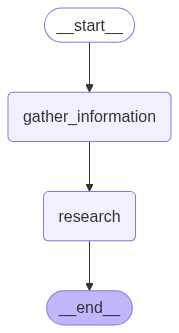

In [50]:
from IPython.display import Image, display
display(Image(research_graph.get_graph().draw_mermaid_png()))

# Testing Research Agent System

In [51]:
def run_research(research_topic: str):
    results = research_graph.invoke({
        "question": research_topic
    })
    # print(f"Results: \n{results}")
    return results

In [52]:
try:
    research_topic = "Quantum Computing"
    output = run_research(research_topic)
    print("Research complete!")
except Exception as e:
    print(f"Research failed due to: {e}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Research complete!


In [53]:
print(output.get("answer"))

answer="Key Topics:\n\n1. Quantum Internet Computing\n2. Quantum Protocols for Distributed Nodes\n3. Quantum Cloud Computing\n4. Delegated Verifiable Blind or Private Computing\n5. Non-local Gates\n6. Distributed Quantum Applications\n7. Unconventional Quantum Computing Devices\n8. Fermionic Quantum Computers\n9. Computers that exploit nonlinear quantum mechanics\n10. Geometrical Perspective on Quantum States and Quantum Computation\n\nFindings/Key Points:\n\n1. Quantum Internet Computing: Quantum Internet computing refers to distributed quantum computing over the quantum Internet, similar to classical Internet computing. It involves quantum protocols for distributed nodes, quantum cloud computing, delegated verifiable blind or private computing, non-local gates, and distributed quantum applications over Internet-scale distances (Loke, 2022).\n2. Quantum Protocols for Distributed Nodes: Quantum protocols for distributed nodes are essential for quantum Internet computing, enabling quant